<a href="https://colab.research.google.com/github/cuomo2236364-create/FDS-20252026/blob/main/fma_dataset999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Loading all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.image as mpimg
import shutil
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split


In [ ]:
# Cloning the GitHub repos of the "fma_small" dataset and the metadata
# [ !! It takes about 5 minutes !! ]

!wget https://os.unil.cloud.switch.ch/fma/fma_small.zip
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

--2025-12-01 16:52:40--  https://os.unil.cloud.switch.ch/fma/fma_small.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7679594875 (7.2G) [application/zip]
Saving to: ‘fma_small.zip’

fma_small.zip        46%[========>           ]   3.32G  23.9MB/s    eta 2m 40s 

In [ ]:
# Unzipping the two folders previously loaded
# [ !! It takes about 15 minutes !! ]

for zip_path in ["fma_small.zip", "fma_metadata.zip"]:
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall()

In [ ]:
AUDIO_DIR = "fma_small"
files = []

for root, dirs, filenames in os.walk(AUDIO_DIR):
    for f in filenames:
        if f.lower().endswith(".mp3"):
            files.append(os.path.join(root, f))

print(f"{len(files)} file MP3 trovati")
print(files[:5])


8000 file MP3 trovati
['fma_small/060/060736.mp3', 'fma_small/060/060146.mp3', 'fma_small/060/060775.mp3', 'fma_small/060/060753.mp3', 'fma_small/060/060042.mp3']


In [ ]:
# Generating four tables (from the metadata) with information regarding the 8.000 audio tracks

tracks = pd.read_csv('fma_metadata/tracks.csv', index_col = 0, header = [0, 1])
genres = pd.read_csv('fma_metadata/genres.csv', index_col = 0)
features = pd.read_csv('fma_metadata/features.csv', index_col = 0, header = [0, 1, 2])
echonest = pd.read_csv('fma_metadata/echonest.csv', index_col = 0, header = [0, 1, 2])

# Printing their shape to check if they've been correctly generated

print("Tracks:", tracks.shape)
print("Genres:", genres.shape)
print("Features:", features.shape)
print("Echonest:", echonest.shape)

Tracks: (106574, 52)
Genres: (163, 4)
Features: (106574, 518)
Echonest: (13129, 249)


ChatGPT regarding the file *features.csv*:

"Sono feature pre-estratte dall’audio usando *librosa*, ma non sono spettrogrammi completi. Non sono dunque adatte per CNN: non sono matrici tempo-frequenza, quanto più valori aggregati."

In [ ]:
audio_dir = "fma_small"
files = []

for root, dirs, filenames in os.walk(audio_dir):
    for f in filenames:
        if f.endswith(".mp3"):
            files.append(os.path.join(root, f))

print(f"----- {len(files)} audio tracks found -----")


----- 8000 audio tracks found -----


In [ ]:
#UPLOADING THE SPECTOGRAM FOLDER
zip_path = "fma_spectrograms.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("fma_spectrograms")
print("✓ ZIP estratto con successo!")



✓ ZIP estratto con successo!


In [ ]:
# Cartella dove vogliamo estrarre le immagini
OUTPUT_DIR = "fma_spectrograms_clean"
os.makedirs(OUTPUT_DIR, exist_ok=True)

with zipfile.ZipFile("fma_spectrograms.zip", "r") as zip_ref:
    # ZIP potrebbe contenere una cartella interna
    for member in zip_ref.namelist():
        # Rimuove eventuale cartella interna (solo il nome del file)
        filename = os.path.basename(member)
        if filename:  # evita le cartelle vuote
            # Scrive direttamente nella nostra cartella OUTPUT_DIR
            source = zip_ref.open(member)
            target_path = os.path.join(OUTPUT_DIR, filename)
            with open(target_path, "wb") as target:
                with source as src:
                    target.write(src.read())

# Controllo
print("Prime immagini estratte:", os.listdir(OUTPUT_DIR)[:5])


Prime immagini estratte: ['62163_Pop.png', '80000_Folk.png', '53301_International.png', '9888_Folk.png', '55242_International.png']


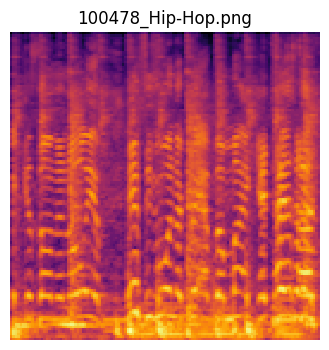

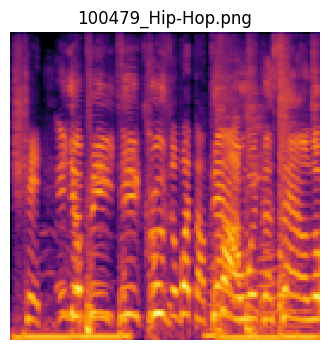

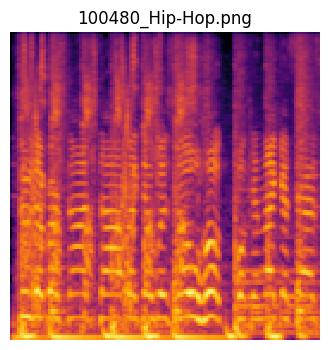

In [ ]:
img_files = sorted(os.listdir(OUTPUT_DIR))[:3]

for img_file in img_files:
    img_path = os.path.join(OUTPUT_DIR, img_file)
    img = mpimg.imread(img_path)

    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file)
    plt.show()



In [ ]:
#CNN works better if the dataset is organized in folders
#Folder Organization
spectrogram_dir = "fma_spectrograms_clean"
dataset_dir = "dataset"
os.makedirs(dataset_dir, exist_ok=True)

tracks = pd.read_csv("fma_metadata/tracks.csv", index_col=0, header=[0,1])

copied = 0
skipped = 0

for fname in os.listdir(spectrogram_dir):
    if not fname.lower().endswith(".png"):
        continue

    track_id_str = fname.split("_")[0]

    try:
        track_id = int(track_id_str)
    except:
        skipped += 1
        continue

    if track_id not in tracks.index:
        skipped += 1
        continue

    genre = tracks.loc[track_id, ('track','genre_top')]
    genre_dir = os.path.join(dataset_dir, genre)
    os.makedirs(genre_dir, exist_ok=True)

    shutil.copy(os.path.join(spectrogram_dir, fname), os.path.join(genre_dir, fname))
    copied += 1

print(f"✅ Copiati {copied} file nelle cartelle dei generi")
print(f"⚠️ Saltati {skipped} file senza corrispondenza")




✅ Copiati 7997 file nelle cartelle dei generi
⚠️ Saltati 0 file senza corrispondenza


In [ ]:
#Check if the file are distrbituited correctly
for genre in sorted(os.listdir(dataset_dir)):
    genre_path = os.path.join(dataset_dir, genre)
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)[:5]
        print(f"{genre}: {files}")


Electronic: ['72215_Electronic.png', '97940_Electronic.png', '52649_Electronic.png', '87643_Electronic.png', '139995_Electronic.png']
Experimental: ['17644_Experimental.png', '44782_Experimental.png', '140939_Experimental.png', '57630_Experimental.png', '122201_Experimental.png']
Folk: ['80000_Folk.png', '9888_Folk.png', '69761_Folk.png', '140788_Folk.png', '144550_Folk.png']
Hip-Hop: ['71230_Hip-Hop.png', '65752_Hip-Hop.png', '146689_Hip-Hop.png', '110262_Hip-Hop.png', '131019_Hip-Hop.png']
Instrumental: ['130934_Instrumental.png', '115771_Instrumental.png', '73495_Instrumental.png', '103522_Instrumental.png', '51776_Instrumental.png']
International: ['53301_International.png', '55242_International.png', '133837_International.png', '62191_International.png', '52123_International.png']
Pop: ['62163_Pop.png', '64840_Pop.png', '28482_Pop.png', '108460_Pop.png', '85423_Pop.png']
Rock: ['133276_Rock.png', '123427_Rock.png', '137724_Rock.png', '72288_Rock.png', '114410_Rock.png']


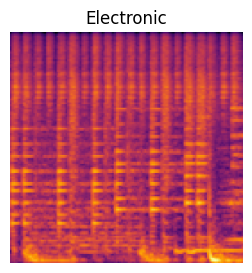

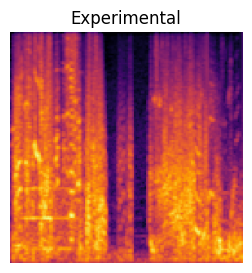

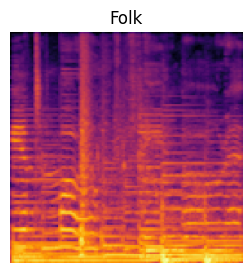

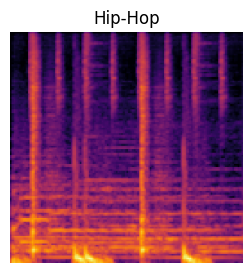

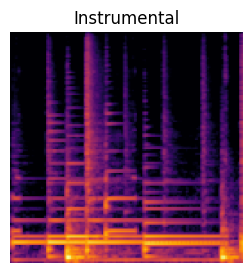

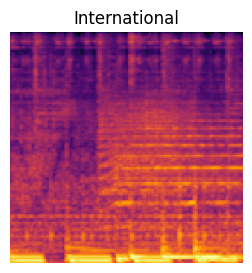

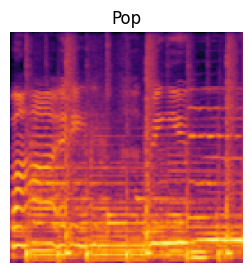

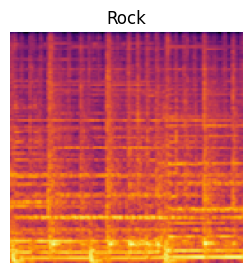

In [ ]:
#Visualization of one image per genre
for genre in sorted(os.listdir(dataset_dir)):
    genre_path = os.path.join(dataset_dir, genre)
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)
        if files:
            img_path = os.path.join(genre_path, files[0])
            img = mpimg.imread(img_path)
            plt.figure(figsize=(6,3))
            plt.imshow(img)
            plt.axis('off')
            plt.title(genre)
            plt.show()


We can clearly see that all  the spectrograms, besides the one for the "Rock" genre, are quite similar.
The spectrogram rapresenting a "Rock" song is clearly not as noisy as the spectrograms rapresenting all the other genres

In [ ]:

#TRANSOFRMATION + DATASET LOADING
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # <-- important!
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(dataset_dir, transform=transform)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# check if everything went good
print("Classi trovate:", dataset.classes)
print("Numero totale di immagini caricate:", len(dataset))


Classi trovate: ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']
Numero totale di immagini caricate: 7997


In [ ]:

#CNN CREATION
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x




In [ ]:
#INITIALIZIING THE CNN
num_classes = len(dataset.classes)
model = SpectrogramCNN(num_classes)
model = model.to(device)  # Moves the model to GPU



In [ ]:
#DEFINE OPTIMIZATION AND LOSS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
#Training cycle (might take a bit!)[1h and 45m]
#loss should be around 0.903 given by -log(1/n° of classes)
# DEVICE

epochs = 5

for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)   # move images to GPU
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")



Epoch 1/5, Loss: 1.881185940027237
Epoch 2/5, Loss: 1.65457395362854
Epoch 3/5, Loss: 1.4606546903848647
Epoch 4/5, Loss: 1.2171877422332764
Epoch 5/5, Loss: 0.8713193396925927


5/5 Epoch , Loss: 1.075

In [ ]:
#save
torch.save(model.state_dict(), "cnn_fma.pth")


In [ ]:
#LETS TRY IT ON A VALIDATION SET AND CHECK THE ACCURACY

# Train/validation split
val_ratio = 0.2
train_size = int(len(dataset) * (1 - val_ratio))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Accuracy sul validation set
model.eval()
correct = sum(
    (torch.max(model(images.to(device)).data, 1)[1] == labels.to(device)).sum().item()
    for images, labels in val_loader
)
total = len(val_dataset)
print(f"Accuracy sul validation set: {100 * correct / total:.2f}%")


Accuracy sul validation set: 89.00%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# Make sure model is in evaluation mode
model.eval()

all_labels, all_preds, all_images, all_filenames = [], [], [], []

# Loop through validation set
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_images.extend(images.cpu())  # keep images for visualization
        # Normalized confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=dataset.classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

# Visualize misclassified examples for certain genres
misclassified_idx = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]



Most of the wrong prediction are predicting electronic istead of hip hop and pop
Also Experimental has a lot of misprediction